In [1]:
! pip uninstall scikit-learn
! pip install scikit-learn==0.21.0
! pip install fireTS

Found existing installation: scikit-learn 1.0.1
Uninstalling scikit-learn-1.0.1:
  Would remove:
    /usr/local/lib/python3.7/dist-packages/scikit_learn-1.0.1.dist-info/*
    /usr/local/lib/python3.7/dist-packages/scikit_learn.libs/libgomp-f7e03b3e.so.1.0.0
    /usr/local/lib/python3.7/dist-packages/sklearn/*
Proceed (y/n)? y
  Successfully uninstalled scikit-learn-1.0.1
     |████████████████████████████████| 6.7 MB 6.8 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
imbalanced-learn 0.8.1 requires scikit-learn>=0.24, but you have scikit-learn 0.21.0 which is incompatible.


In [2]:
from sklearn.neural_network import MLPRegressor
from fireTS.models import NARX

!pip install neurolab
!pip install pyrenn

import neurolab as nl
import numpy as np
import numpy.matlib
import pylab as pl
from sklearn.metrics import mean_squared_error
import pyrenn
from matplotlib import pyplot as plt
import math
import random
import pandas as pd
!pip install tensorflow==2.1
!pip install keras==2.3.1
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense

     |████████████████████████████████| 645 kB 7.6 MB/s 
  Created wheel for neurolab: filename=neurolab-0.3.5-py3-none-any.whl size=22179 sha256=bd1a6e9edc1e414a3d7c6e43692cfedd40921643d507ede91dc17b08ac418194
  Stored in directory: /root/.cache/pip/wheels/3e/07/63/e3d6e066089d7186465184a6f9a1884471485f38beef1edeaa
Successfully built neurolab
  Created wheel for pyrenn: filename=pyrenn-0.1-py3-none-any.whl size=9257 sha256=51c5624e1f6ea6bf9e36efe1130ffece93a34af20a5a23c26651da8f6089d50d
  Stored in directory: /root/.cache/pip/wheels/00/36/ed/55abd022626413ad5e39d84b25cdd487f4ee8b38ba59e5aa29
Successfully built pyrenn
     |████████████████████████████████| 421.8 MB 24 kB/s 
     |████████████████████████████████| 448 kB 59.4 MB/s 
     |████████████████████████████████| 50 kB 7.0 MB/s 
     |████████████████████████████████| 3.8 MB 34.5 MB/s 
  Created wheel for gast: filename=gast-0.2.2-py3-none-any.whl size=7554 sha256=f0c1557b0567daeecda0fd23b966f995eee1c5be82f9187ff88c4ec963da8485

Using TensorFlow backend.


In [3]:
data = pd.read_csv('SN_m_tot_V2.0.csv', sep=';', header=None)

In [4]:
data

,0,1,2,3,4,5,6
0,1749,1,1749.042,96.7,-1.0,-1,1
1,1749,2,1749.123,104.3,-1.0,-1,1
2,1749,3,1749.204,116.7,-1.0,-1,1
3,1749,4,1749.288,92.8,-1.0,-1,1
4,1749,5,1749.371,141.7,-1.0,-1,1
...,...,...,...,...,...,...,...
3270,2021,7,2021.538,34.4,9.1,1222,0
3271,2021,8,2021.623,22.4,7.7,1250,0
3272,2021,9,2021.705,51.5,9.6,1151,0
3273,2021,10,2021.790,38.1,8.2,1124,0


In [5]:
data = data.iloc[:, 0:4]
data = data.drop([2], axis=1)
data.columns = ['Year', 'Month', 'Value']
data.Year = data.Year.astype(str)
data.Month = data.Month.astype(str)
data.index = pd.to_datetime(data.Year + '-' + data.Month)
data.drop(['Year'], axis=1, inplace=True)
data.drop(['Month'], axis=1, inplace=True)

In [6]:
data.head()

,Value
1749-01-01,96.7
1749-02-01,104.3
1749-03-01,116.7
1749-04-01,92.8
1749-05-01,141.7


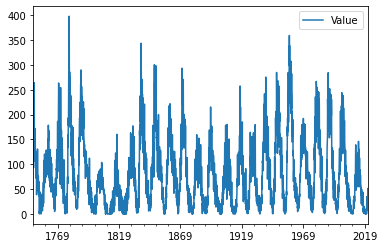

In [7]:
data.plot()

In [8]:
data.shape

(3275, 1)

In [9]:
date = "1860-10-1"

In [10]:
def smooth(a, L, S):  # Window len = L, Stride len/stepsize = S
    nrows = ((a.size-L)//S)+1
    n = a.strides[0]
    return np.lib.stride_tricks.as_strided(a, shape=(nrows,L), strides=(S*n,n))

kek = np.mean(smooth(data.values, 12, 1), axis=1)

In [11]:
shift = data.shape[0] - kek.shape[0]
data.iloc[shift:] = kek[:, np.newaxis]

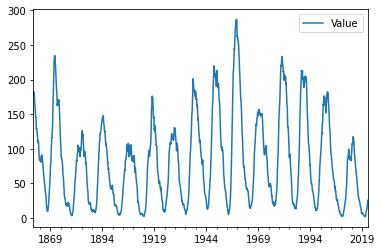

In [12]:
data = data[data.index >= pd.to_datetime(date)]
data.plot();

In [13]:
data.shape

(1934, 1)

In [14]:
# convert an array of values into a dataset matrix
def create_dataset(df, look_back=1):
    y = df.iloc[look_back:].values
    tmp = df.values.flatten()
    x = np.array([tmp[i:i+look_back] for i in range(len(tmp) - look_back)])
    return x, y

In [15]:
train_size = int(len(data) * 0.70)
test_size = len(data) - train_size
train, test = data[:train_size], data[train_size:]


In [16]:
D = 5
trainX, trainY = create_dataset(train, D)
testX, testY = create_dataset(test, D)

In [17]:
model = Sequential()
model.add(Dense(12, input_dim=D, activation='relu'))
model.add(Dense(8, activation='linear'))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
error = model.fit(trainX, trainY, epochs=100, batch_size=10,verbose=0)

In [18]:
trainScore = model.evaluate(trainX, trainY)
print('Train Score: %.2f MSE (%.2f RMSE)' % (trainScore, np.sqrt(trainScore)))

1348/1348 [==============================] - 0s 41us/step
Train Score: 8.44 MSE (2.90 RMSE)


In [19]:
testScore = model.evaluate(testX, testY)
print('Test Score: %.2f MSE (%.2f RMSE)' % (testScore, np.sqrt(testScore)))

576/576 [==============================] - 0s 60us/step
Test Score: 7.33 MSE (2.71 RMSE)


In [20]:
predictTrain = model.predict(trainX)

MSE = mean_squared_error(trainY, predictTrain)
print('MSE = {}'.format(MSE))
print('RMSE = {}'.format(np.sqrt(MSE)))

MSE = 8.438164487067832
RMSE = 2.9048518872857927


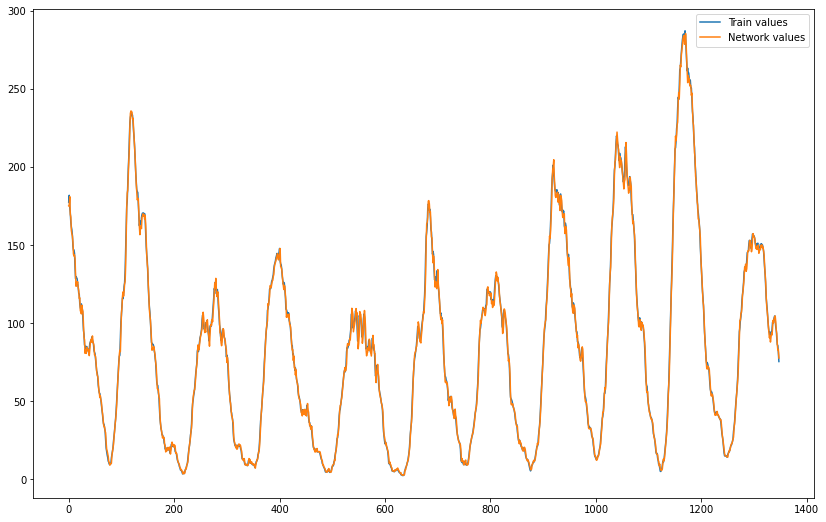

In [21]:
plt.figure(figsize=(14, 9))

plt.plot(trainY)
plt.plot(predictTrain)

plt.legend(['Train values', 'Network values'])
plt.show()

In [22]:
predictTest = model.predict(testX)
MSE = mean_squared_error(testY, predictTest)
print('MSE = {}'.format(MSE))
print('RMSE = {}'.format(np.sqrt(MSE)))

MSE = 7.326229078339902
RMSE = 2.706700773698471


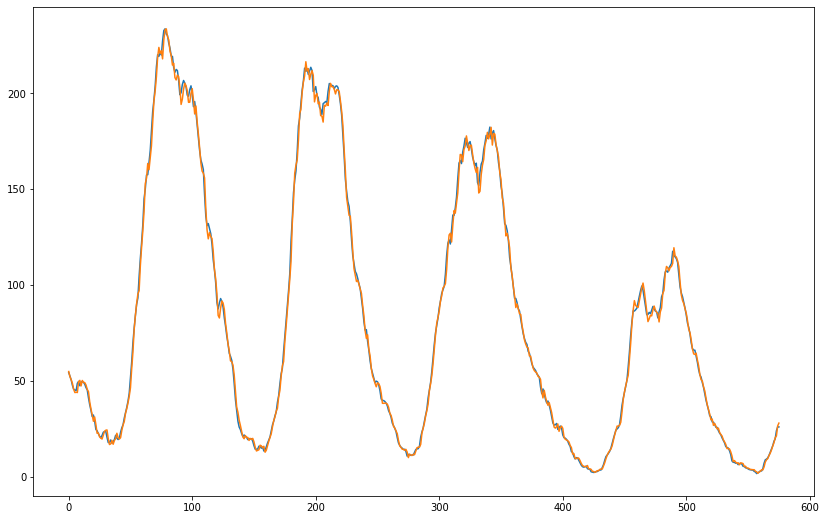

In [23]:
plt.figure(figsize=(14, 9))
plt.plot(testY)
plt.plot(predictTest)

### Задание 2

In [24]:
def g(k):
    return np.cos(-2*k * k + 7 * k)

def k_range(a, b, h):
    return np.linspace(a, b, int((b - a)/h))

p1 = np.sin(4*np.pi*k_range(0, 1, 0.025))
p2 = g(k_range(0.92, 4.07, 0.025))
t1 = [-1]*p1.size
t2 = [1]*p2.size
r = (2, 4, 7)

def repmat(p, r):
    return np.hstack([p for _ in range(r)]) if r else np.array([])

P = np.hstack([repmat(p1, r[0]), p2, repmat(p1, r[1]), p2, repmat(p1, r[2]), p2])
T = np.hstack([repmat(t1, r[0]), t2, repmat(t1, r[1]), t2, repmat(t1, r[2]), t2])

P_new = np.hstack([repmat(p1, r[0]), p2, repmat(p1, r[1]), p2, repmat(p1, 12), p2])
T_new = np.hstack([repmat(t1, r[0]), t2, repmat(t1, r[1]), t2, repmat(t1, 12), t2])

In [25]:
df2 = pd.DataFrame({'input' : P.flatten(), 'output' : T.flatten()})
df3 = pd.DataFrame({'input' : P_new.flatten(), 'output' : T_new.flatten()})

In [26]:
# convert an array of values into a dataset matrix
def create_dataset(df, look_back=1):
    y = df.output.iloc[look_back:].values
    tmp = df.input.values.flatten()
    x = np.array([tmp[i:i+look_back] for i in range(len(tmp) - look_back)])
    return x, y

np.random.seed(7)

D = 5
trainX, trainY = create_dataset(df2, D)

model = Sequential()
model.add(Dense(12, input_dim=D, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=10, verbose=0)

trainScore = model.evaluate(trainX, trainY, verbose=0)
print('Train Score: %.2f MSE (%.2f RMSE)' % (trainScore, np.sqrt(trainScore)))

Train Score: 0.06 MSE (0.24 RMSE)


In [27]:
output = model.predict(trainX)

In [28]:
output.shape

(893, 1)

In [29]:
df2 = df2[D:]

In [30]:
df2.shape

(893, 2)

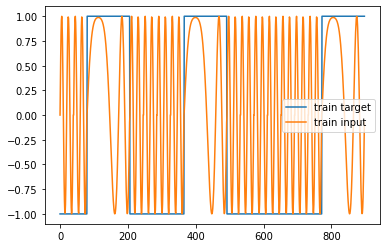

In [170]:
pl.plot(T.reshape(T.shape))
pl.plot(P.reshape(P.shape))
pl.legend(['train target', 'train input'])
pl.show()

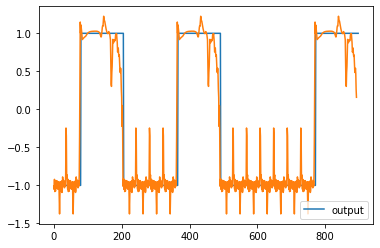

In [31]:
df2[['output']].plot();
plt.plot(output)

In [32]:
output[output >= 0] = 1.0
output[output < 0] = -1.0

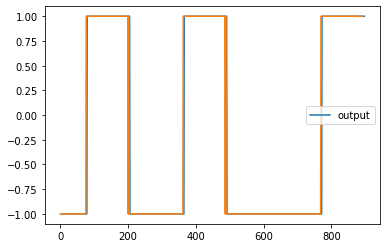

In [33]:
df2[['output']].plot();
plt.plot(output)

In [34]:
print("Количество точек :", len(T), sep=' ')
print("Количество правильно классифицированных точек :", (output == df2[['output']]).sum(), sep = ' ')
print("Accuracy: ", (output == df2[['output']]).sum() / len(T))

Количество точек : 898
Количество правильно классифицированных точек : output    885
dtype: int64
Accuracy:  output    0.985523
dtype: float64


In [40]:
D = 5
trainX_new, trainY_new = create_dataset(df3, D)
output2 = model.predict(trainX_new)
df3 = df3[D:]

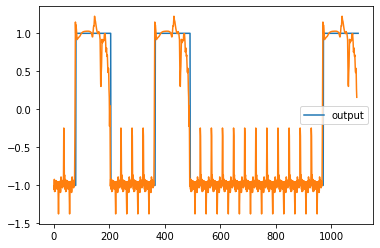

In [41]:
df3[['output']].plot();
plt.plot(output2)

In [42]:
output2[output2 >= 0] = 1.0
output2[output2 < 0] = -1.0

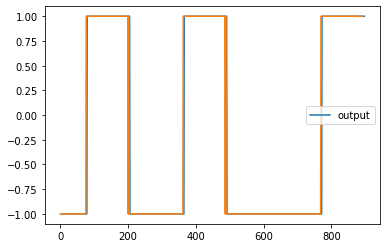

In [43]:
df2[['output']].plot();
plt.plot(output)

In [44]:
print("Количество точек :", len(T_new), sep=' ')
print("Количество правильно классифицированных точек :", (output2 == df3[['output']]).sum(), sep = ' ')
print("Accuracy: ", (output2 == df3[['output']]).sum() / len(T_new))

Количество точек : 1098
Количество правильно классифицированных точек : output    1085
dtype: int64
Accuracy:  output    0.98816
dtype: float64


### Задание 3

In [156]:
def u(k):
  return np.sin(-2 * k + 7 * k)

h = 0.01
k = np.linspace(0, 10, (int)(10/h))

y = [0.]
for i in k:
    y.append(y[-1] / (1 + y[-1]**2) + u(i)**3)

y = np.array(y[:-1])

In [157]:
D = 3
trainSize = 700
controlSize = 200
testSize = 97

In [158]:
xTrain = k[: trainSize]
xTest = k[trainSize : trainSize + controlSize]
xValid = k[trainSize + controlSize : trainSize + controlSize * testSize]

yTrain = y[: trainSize]
yTest = y[trainSize : trainSize + controlSize]
yValid = y[trainSize + controlSize : trainSize + controlSize * testSize]

In [159]:
input = u(k)[:, np.newaxis]
target = y

In [160]:
narx = NARX(MLPRegressor(hidden_layer_sizes=(10, 10)), solver='lbfgs', max_iter=600, auto_order=2, exog_order=[2], exog_delay=[1])

In [161]:
narx.fit(input, target)

In [162]:
output = narx.predict(input, target, step=1)

In [163]:
output[np.isnan(output)] = 0
MSE = mean_squared_error(target, output)

print('MSE = {}'.format(MSE))
print('RMSE = {}'.format(np.sqrt(MSE)))

MSE = 6.586686060233043e-05
RMSE = 0.008115840104532028


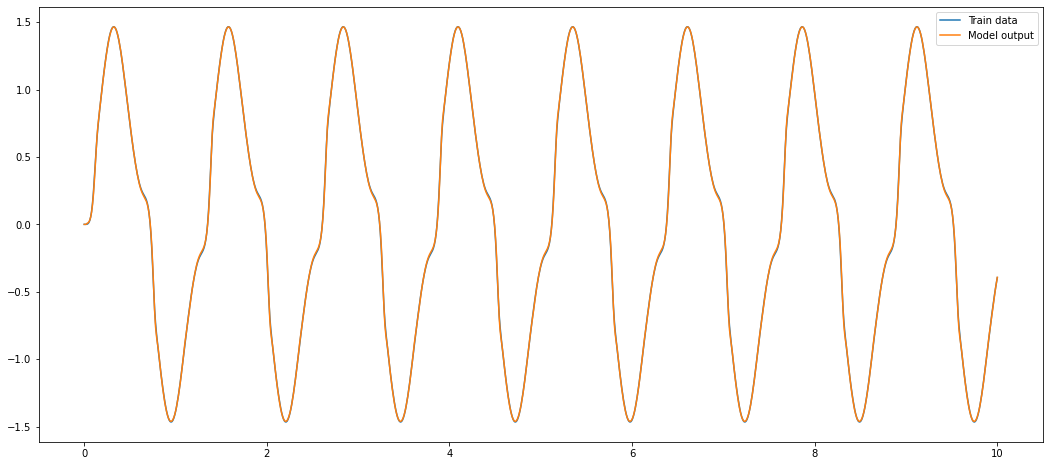

In [164]:
plt.figure(figsize=(18, 8))

plt.plot(k, y)
plt.plot(k, output)
plt.legend(['Train data', 'Model output'])
plt.show()

In [165]:
input2 = u(xTest)[:, np.newaxis]
target2 = yTest
output2 = narx.predict(input2, target2, step=1)

In [166]:
output2[np.isnan(output2)] = 0
MSE = mean_squared_error(target2, output2)

print('MSE = {}'.format(MSE))
print('RMSE = {}'.format(np.sqrt(MSE)))

MSE = 0.00040929022461894614
RMSE = 0.020230922485614592


In [167]:
shift = 10

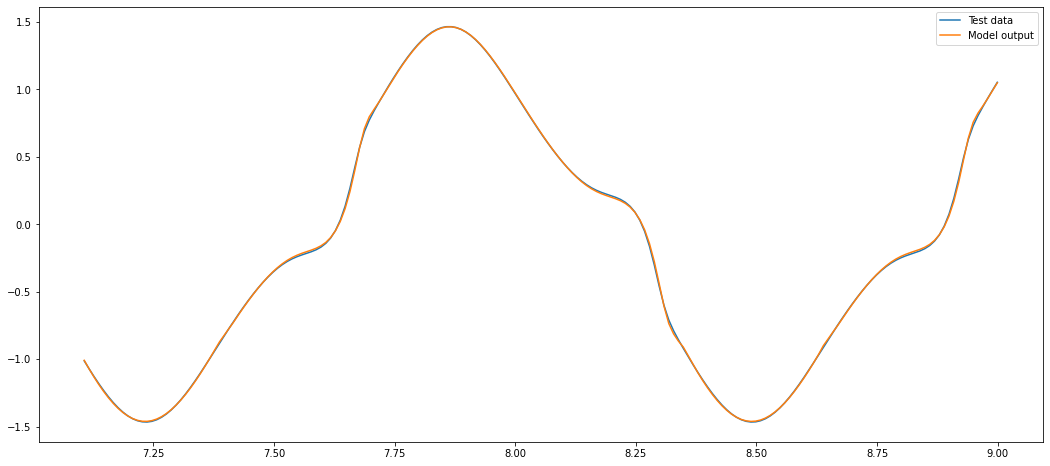

In [169]:
plt.figure(figsize=(18, 8))

plt.plot(xTest[shift:], yTest[shift:])
plt.plot(xTest[shift:], output2[shift:])
plt.legend(['Test data', 'Model output'])
plt.show()